## keywordのコサイン類似度

In [1]:
file_num = '014'

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ginza
import spacy
import torch
import transformers
from transformers import BertJapaneseTokenizer
from tqdm import tqdm
tqdm.pandas()
%matplotlib inline

In [3]:
def removeZenkakuSpace(df, cols):
    for col in cols:
        df[col] = df[col].str.replace('　', ' ')
    return df

def histEachFavs(df, col, height=3, aspect=4, title=''):
    '''
    FAVごとのカラムの要素のヒストグラム
    '''
    for fav in sorted(df[FAV].unique()):
        sns.catplot(x=col,data=df.query(f"{FAV} == @fav"),kind='count',height=height, aspect=aspect)
        plt.title(f'{title} fav group:{fav}')
        
def getQueries(df, cols):
    assert type(cols) == str or type(cols) == list, 'cols is str or list'
    queries = []
    if type(cols) == str:
        queries = [f'{cols} == {flag}' for flag in sorted(df[cols].unique())]
    elif type(cols) == list:
        for col in cols:
            col_queries = [f'{col} == {flag}' for flag in sorted(df[col].unique())]
            if len(queries) == 0:
                queries = col_queries
            else:
                queries = [f"{q} & {col_queries[0]}" for q in queries] + [f'{q} & {col_queries[1]}' for q in queries]
            
    return queries

def columnUnique(df, col):
    return sorted(df[col].unique())

def histColumnsFavs(df, cols:list, height=3, aspect=6, title=''):
    '''
    カラムの要素に対するのFAVの数のヒストグラム
    colsがlistのときは複数カラムの要素ごと
    '''
    queries = getQueries(df, cols)
    for query in queries:
        data = df.query(query)
        if len(data) == 0:
            continue
        sns.catplot(x=FAV,data=data,kind='count',height=height, aspect=aspect)
        plt.title(f'{title} {query}')
        
def histEachFavsByCategory(df, df_target, col):
    '''
    
    '''
    cats = sorted(df[col].unique())
    for cat in cats:
        fig, axes = plt.subplots(figsize=(30,10), ncols=3, nrows=2)
        for ax, fav in zip(axes.ravel(), favs):
            target_mask = (df[FAV] == fav) & (df[col] == cat)
            ax.hist(df_target.loc[target_mask], bins=100)
            ax.set_xlim(-1,df_target.max())
            ax.set_title(f'category:{cat}, fav:{fav}, num={target_mask.sum()}')

In [4]:
out_dir = '../output'
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
ID = 'ncode'
FAV = 'fav_novel_cnt_bin'
favs = sorted(train_df[FAV].unique())

train_df.userid = train_df.userid.astype('str')
train_df.genre = train_df.genre.astype('str')
test_df.userid = test_df.userid.astype('str')
test_df.genre = test_df.genre.astype('str')
str_cols = ['title', 'story', 'keyword', 'writer']
train_df = removeZenkakuSpace(train_df, str_cols)
test_df = removeZenkakuSpace(test_df, str_cols)


In [5]:
train_df.columns

Index(['ncode', 'general_firstup', 'title', 'story', 'keyword', 'userid',
       'writer', 'biggenre', 'genre', 'novel_type', 'end', 'isstop', 'isr15',
       'isbl', 'isgl', 'iszankoku', 'istensei', 'istenni', 'pc_or_k',
       'fav_novel_cnt_bin'],
      dtype='object')

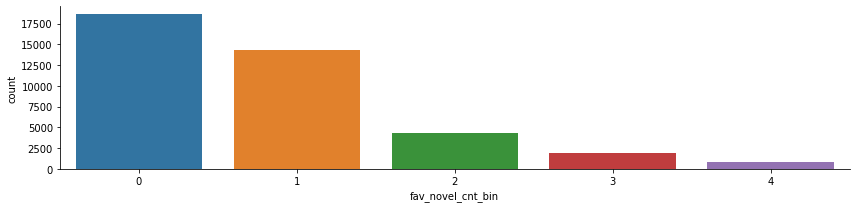

In [6]:
sns.catplot(x=FAV, data=train_df, kind='count', height=3,aspect=4)

In [7]:
if 'nlp' not in locals():
    nlp = spacy.load("ja_ginza")
    print('load ginza')

load ginza


In [8]:
mask_no_keyword = ~train_df.keyword.isnull()
train_df.keyword = train_df.keyword.fillna('')

In [9]:
class BertSequenceVectorizer:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(self.model_name)
        self.bert_model = transformers.BertModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 128
            

    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)
        
        seq_out = self.bert_model(inputs_tensor, masks_tensor)[0]
        pooled_out = self.bert_model(inputs_tensor, masks_tensor)[1]

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy() # 0番目は [CLS] token, 768 dim の文章特徴量
        else:
            return seq_out[0][0].detach().numpy()

In [70]:
def applySpacyToKeyword(keywords):
    return np.vectorize(lambda keyword: nlp(str(keyword)))(keywords)

def applySpacyToRow(row):
    keywords = row.split()
    global pbar
    pbar.update(1)
    return BSV.vectorize(keywords)
    

In [74]:
train_df[:3].loc[mask_no_keyword]['keyword_vectorize'] = applySpacyToRow(train_df[:3].loc[mask_no_keyword].keyword)

AttributeError: 'Series' object has no attribute 'split'

In [15]:
BSV = BertSequenceVectorizer()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
train_df[:3].loc[mask_no_keyword]['keyword_vectorize'] = applySpacyToRow(train_df[:3].loc[mask_no_keyword].keyword)

AttributeError: 'Series' object has no attribute 'split'

In [ ]:
train_df[:3].loc[mask_no_keyword]['vectorize'] = np.vectorize(lambda x : BSV.vectorize(x))(train_df[:3].title)

In [72]:
with tqdm(total=sum(mask_no_keyword)) as pbar:
    train_df.loc[mask_no_keyword]['keywords_vectrize'] = np.vectorize(applySpacyToRow)(train_df.loc[mask_no_keyword]['keyword'].values)

 10%|█         | 3944/37774 [01:05<09:21, 60.29it/s]


KeyboardInterrupt: 

In [42]:
train_df['keywords'] = train_df.keyword.str.split()

In [44]:
np.vectorize(test, excluded='b')(a=train_df[:2]['writer'], c=train_df[:2]['genre'],b=train_df[:2][['ncode','writer']])

梅田浩志
402
    ncode writer
0  N7588B   梅田浩志
1  N8726B     ルト
梅田浩志
402
    ncode writer
0  N7588B   梅田浩志
1  N8726B     ルト
ルト
401
    ncode writer
0  N7588B   梅田浩志
1  N8726B     ルト


array([None, None], dtype=object)